# Plotting age distributions with respect to genotype groups

 0 W:0.8609 p:0.0000 - 58 subjects between 50 and 67
1 W:0.8885 p:0.0637 - 15 subjects between 55 and 67
2 W:0.9429 p:0.4561 - 14 subjects between 50 and 66


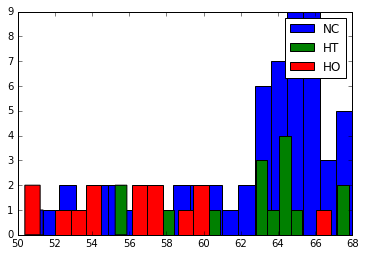

In [4]:
%matplotlib inline
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

import json
data = pd.read_excel('/tmp/analysis_amylstaging/amyl_covariates.xlsx')
subjects_amylneg = json.load(open('/tmp/amyloid_negative.json'))
data = data[data['subject'].isin(subjects_amylneg)]

for i in xrange(3):
    x = data[data['apoe'] == i]['age'].values
    plt.hist(x, bins=20)
    print i, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

plt.legend(['NC', 'HT', 'HO'])
plt.show()

For two of the 5 groups, the Shapiro test p-value is lower than 1e-3, which means that the distributions of these two groups can't be considered as normal. (But theorically none of them is)

# Matching pairs using nearest neighbours

The matching algorithm:

In [233]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

def get_matching_pairs(treated_df, non_treated_df, scaler=True):

    treated_x = treated_df.values
    non_treated_x = non_treated_df.values
    if scaler:
        scaler = StandardScaler()
        scaler.fit(treated_x)
        treated_x = scaler.transform(treated_x)
        non_treated_x = scaler.transform(non_treated_x)

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(non_treated_x)
    distances, indices = nbrs.kneighbors(treated_x)
    indices = indices.reshape(indices.shape[0])    
    matched = non_treated_df.ix[indices]
    matched = non_treated_df.irow(matched.index)
    return matched

#### Loading data

In [234]:
df = pd.read_excel('/home/grg/spm/data/covariates.xls')
df = df[['subject','apo','age','gender','educyears']]

groups = [df[df['apo']==i] for i in xrange(5)]
for i in xrange(5):
    groups[i] = groups[i].set_index(groups[i]['subject'])
    del groups[i]['subject']
    del groups[i]['apo']

### Matching the groups

In [235]:
treated_df =  groups[4]
matched_df = [get_matching_pairs(treated_df, groups[i], scaler=False) for i in xrange(4)]

/home/grg/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: irow(i) is deprecated. Please use .iloc[i]


#### Plotting data and see that the groups are now matching

0 W:0.9165 p:0.0003 - 65 subjects between 46 and 66
1 W:0.9271 p:0.0009 - 65 subjects between 45 and 67
2 W:0.9295 p:0.0012 - 65 subjects between 45 and 68
3 W:0.9163 p:0.0003 - 65 subjects between 46 and 68
4 W:0.9306 p:0.0013 - 65 subjects between 45 and 67


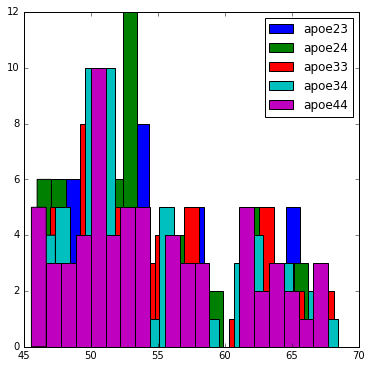

In [236]:
fig, ax = plt.subplots(figsize=(6,6))

for i in xrange(4):
    x = matched_df[i]['age']
    plt.hist(x, bins=20)   
    print i, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))
    
x = treated_df['age']
plt.hist(x, bins=20)   
print 4, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

plt.legend(['apoe23', 'apoe24', 'apoe33', 'apoe34', 'apoe44'])

# Matching groups using linear assignment method

In [5]:
import pandas as pd
df = pd.read_excel('/tmp/analysis_amylstaging/amyl_covariates.xlsx')
df = df[['subject','apoe','age','gender']]

groups = [df[df['apoe']==i] for i in xrange(3)]
for i in xrange(3):
    groups[i] = groups[i].set_index(groups[i]['subject'])
    del groups[i]['subject']
    del groups[i]['apoe']

In [6]:
groups = [df[df['apoe']==i] for i in xrange(3)]
for i in xrange(3):
    groups[i] = groups[i].set_index(groups[i]['subject'])
    del groups[i]['apoe']
    del groups[i]['subject']
treated_df =  groups[-1]
non_treated_df = groups[0]

In [7]:
from scipy.spatial.distance import cdist
from scipy import optimize

def get_matching_pairs(treated_df, non_treated_df):
    cost_matrix = cdist(treated_df.values, non_treated_df.values)
    row_ind, col_ind = optimize.linear_sum_assignment(cost_matrix)
    return non_treated_df.iloc[col_ind]

In [9]:
treated_df =  groups[-1]
matched_df = [get_matching_pairs(treated_df, groups[i]) for i in xrange(2)]


#### Plotting data and see that the groups are now matching

0 W:0.9540 p:0.5228 - 17 subjects between 50 and 66
1 W:0.8836 p:0.0363 - 17 subjects between 55 and 66
2 W:0.9396 p:0.3139 - 17 subjects between 50 and 66


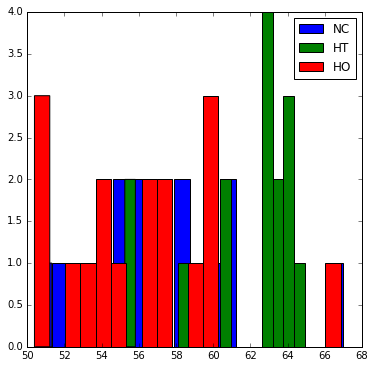

In [14]:
fig, ax = plt.subplots(figsize=(6,6))

for i in xrange(2):
    x = matched_df[i]['age']
    plt.hist(x, bins=20)   
    print i, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))
    
x = treated_df['age']
plt.hist(x, bins=20)   
print 2, 'W:%.4f p:%.4f -'%stats.shapiro(x), len(x), 'subjects between', int(min(x)), 'and', int(max(x))

plt.legend(['NC', 'HT', 'HO'])

In [20]:
import json
groups_index = [each.index.tolist() for each in matched_df]
groups_index.append(groups[2].index.tolist())
json.dump(groups_index, open('/tmp/groups.json','w'))

### Assessing the effect from the matching

We perform a two-sample t-test between each group and the target group, before and after applying the matching.
As the dataset is composed of 3 variables (age, gender, education), this returns 3 t values and 3 p-values for each comparison.

In [13]:
from scipy.stats import ttest_ind
for i in xrange(2):
    print '=== Group %s ==='%i
    tval_bef, pval_bef = ttest_ind(groups[i].values, treated_df.values)
    tval_aft, pval_aft = ttest_ind(matched_df[i].values, treated_df.values)
    print 'p-values before matching: %s - p-values after matching: %s'%(pval_bef, pval_aft)

=== Group 0 ===
p-values before matching: [6.97275841e-08 1.17449673e-01] - p-values after matching: [0.63778662 0.03161072]
=== Group 1 ===
p-values before matching: [1.16451060e-07 3.82919716e-01] - p-values after matching: [7.45376563e-05 3.14674865e-01]


In [19]:
len(groups[1].values)

28

The p-values observe an overall increase after the matching, showing that the samples are more likely to follow the same distribution law after than before.